In [2]:
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from tqdm import tqdm
import pandas as pd
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Merge, Activation, Flatten
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
import nltk

Using TensorFlow backend.


In [3]:
token = '/usr/local/data/bonniehu/flickr_data/Flickr8k.token.txt'

In [4]:
captions = open(token, 'r').read().strip().split('\n')

## Creating a dictionary containing all the captions of the images

In [5]:
d = {}
for i, row in enumerate(captions):
    row = row.split('\t')
    row[0] = row[0][:len(row[0])-2]
    if row[0] in d:
        d[row[0]].append(row[1])
    else:
        d[row[0]] = [row[1]]

In [6]:
d['1000268201_693b08cb0e.jpg']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [7]:
images = '/usr/local/data/bonniehu/flickr_data/Flicker8k_Dataset/'

In [8]:
# Contains all the images
img = glob.glob(images+'*.jpg')

In [9]:
img[:5]

['/usr/local/data/bonniehu/flickr_data/Flicker8k_Dataset/3638992163_a085cc0c24.jpg',
 '/usr/local/data/bonniehu/flickr_data/Flicker8k_Dataset/3315110972_1090d11728.jpg',
 '/usr/local/data/bonniehu/flickr_data/Flicker8k_Dataset/469617651_278e586e46.jpg',
 '/usr/local/data/bonniehu/flickr_data/Flicker8k_Dataset/2648310638_d6c576b5e4.jpg',
 '/usr/local/data/bonniehu/flickr_data/Flicker8k_Dataset/2836703077_fa9c736203.jpg']

In [10]:
train_images_file = '/usr/local/data/bonniehu/flickr_data/Flickr_8k.trainImages.txt'

In [11]:
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

In [12]:
def split_data(l):
    temp = []
    for i in img:
        if i[len(images):] in l:
            temp.append(i)
    return temp

In [13]:
# Getting the training images from all the images
train_img = split_data(train_images)
len(train_img)

6000

In [14]:
val_images_file = '/usr/local/data/bonniehu/flickr_data/Flickr_8k.devImages.txt'
val_images = set(open(val_images_file, 'r').read().strip().split('\n'))

In [15]:
# Getting the validation images from all the images
val_img = split_data(val_images)
len(val_img)

1000

In [16]:
test_images_file = '/usr/local/data/bonniehu/flickr_data/Flickr_8k.testImages.txt'
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

In [17]:
# Getting the testing images from all the images
test_img = split_data(test_images)
len(test_img)

1000

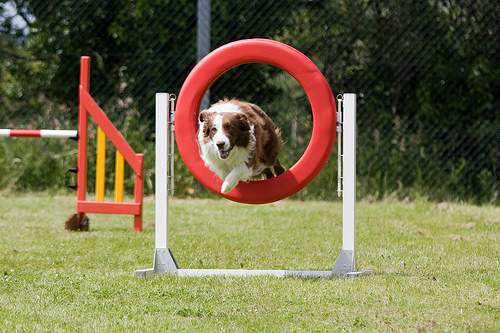

In [18]:
Image.open(train_img[0])

We will feed these images to VGG-16 to get the encoded images. Hence we need to preprocess the images as the authors of VGG-16 did. The last layer of VGG-16 is the softmax classifier(FC layer with 1000 hidden neurons) which returns the probability of a class. This layer should be removed so as to get a feature representation of an image. We will use the last Dense layer(4096 hidden neurons) after popping the classifier layer. Hence the shape of the encoded image will be (1, 4096)

In [19]:
def preprocess_input(x):
    x /= 255.
    #x -= 0.5
    #x *= 2.
    return x

In [20]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    x = preprocess_input(x)
    return x

In [21]:
train_img[0]

'/usr/local/data/bonniehu/flickr_data/Flicker8k_Dataset/3638992163_a085cc0c24.jpg'

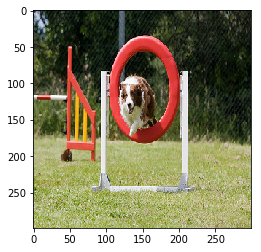

In [22]:
plt.imshow(np.squeeze(preprocess(train_img[0])))

In [23]:
model = InceptionV3(weights='imagenet')

In [24]:
from keras.models import Model

new_input = model.input
hidden_layer = model.layers[-2].output

model_new = Model(new_input, hidden_layer)

In [25]:
tryi = model_new.predict(preprocess(train_img[0]))

In [26]:
tryi.shape

(1, 2048)

In [27]:
tryi[0][123:134]

array([-0.27686465, -0.42232892,  0.38360208, -0.10394152,  0.15087572,
       -0.10646754,  0.18508145,  0.06374402, -0.32219702, -0.22245812,
        0.03081149], dtype=float32)

In [28]:
def encode(image):
    image = preprocess(image)
    temp_enc = model_new.predict(image)
    temp_enc = np.reshape(temp_enc, temp_enc.shape[1])
    return temp_enc

In [33]:
encoding_train = {}
for img in tqdm(train_img):
    encoding_train[img[len(images):]] = encode(img)

  2%|▏         | 102/6000 [00:53<51:22,  1.91it/s]

KeyboardInterrupt: 

In [36]:
with open("encoded_images_inceptionV3.p", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle) 

In [34]:
encoding_train = pickle.load(open('encoded_images_inceptionV3.p', 'rb'))

FileNotFoundError: [Errno 2] No such file or directory: 'encoded_images_inceptionV3.p'

In [18]:
encoding_train['3556792157_d09d42bef7.jpg'].shape

(2048,)

In [82]:
encoding_test = {}
for img in tqdm(test_img):
    encoding_test[img[len(images):]] = encode(img)


 30%|███       | 303/1000 [02:49<06:28,  1.79it/s]


 60%|██████    | 605/1000 [05:37<03:40,  1.79it/s]


 91%|█████████ | 907/1000 [08:26<00:51,  1.79it/s]


100%|██████████| 1000/1000 [09:19<00:00,  1.79it/s]


In [100]:
with open("encoded_images_test_inceptionV3.p", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle) 

In [19]:
encoding_test = pickle.load(open('encoded_images_test_inceptionV3.p', 'rb'))

In [20]:
encoding_test[test_img[0][len(images):]].shape

(2048,)

In [29]:
train_d = {}
for i in train_img:
    if i[len(images):] in d:
        train_d[i] = d[i[len(images):]]

In [30]:
len(train_d)

6000

In [31]:
train_d[images+'3556792157_d09d42bef7.jpg']

['A bunch of children sitting in chairs and standing on wooden floors .',
 'A group of children sit , stand , and kneel along a wall .',
 'A group of children sitting on folding chairs and playing .',
 'a young group of children sitting in a row against the wall .',
 'The kids talking while sitting on a row of chairs along the wall .']

In [32]:
val_d = {}
for i in val_img:
    if i[len(images):] in d:
        val_d[i] = d[i[len(images):]]

In [33]:
len(val_d)

1000

In [34]:
test_d = {}
for i in test_img:
    if i[len(images):] in d:
        test_d[i] = d[i[len(images):]]

In [35]:
len(test_d)

1000

Calculating the unique words in the vocabulary.

In [36]:
caps = []
for key, val in train_d.items():
    for i in val:
        caps.append('<start> ' + i + ' <end>')

In [37]:
words = [i.split() for i in caps]

In [38]:
unique = []
for i in words:
    unique.extend(i)

In [39]:
unique = list(set(unique))

In [87]:
with open("unique_words.p", "wb") as pickle_d:
     pickle.dump(unique, pickle_d) 

In [88]:
unique_load = pickle.load(open('unique.p', 'rb'))

In [42]:
len(unique)

8256

In [89]:
unique_load[5550:5556]

['energizer', 'joust', 'agents', '<start>', 'towels', 'what']

Mapping the unique words to indices and vice-versa

In [43]:
word2idx = {val:index for index, val in enumerate(unique)}

In [44]:
word2idx['<start>']

5553

In [45]:
idx2word = {index:val for index, val in enumerate(unique)}

In [47]:
idx2word[5553]

'<start>'

Calculating the maximum length among all the captions

In [48]:
max_len = 0
for c in caps:
    c = c.split()
    if len(c) > max_len:
        max_len = len(c)
max_len

40

In [49]:
len(unique), max_len

(8256, 40)

In [50]:
vocab_size = len(unique)

In [51]:
vocab_size

8256

Adding <start> and <end> to all the captions to indicate the starting and ending of a sentence. This will be used while we predict the caption of an image

In [52]:
f = open('flickr8k_training_dataset.txt', 'w')
f.write("image_id\tcaptions\n")

18

In [53]:
for key, val in train_d.items():
    for i in val:
        f.write(key[len(images):] + "\t" + "<start> " + i +" <end>" + "\n")

f.close()

In [54]:
df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')

In [55]:
len(df)

30000

In [56]:
c = [i for i in df['captions']]
len(c)

30000

In [57]:
imgs = [i for i in df['image_id']]

In [58]:
a = c[-1]
a, imgs[-1]

('<start> A young girl with a white dress walks down a dirt road with trees and fields on both sides of the road . <end>',
 '2587696611_db0378710f.jpg')

In [59]:
for i in a.split():
    print (i, "=>", word2idx[i])

<start> => 5553
A => 4228
young => 7270
girl => 2482
with => 4350
a => 32
white => 2970
dress => 6704
walks => 7357
down => 2383
a => 32
dirt => 538
road => 6492
with => 4350
trees => 4231
and => 492
fields => 2356
on => 803
both => 103
sides => 1795
of => 3747
the => 7392
road => 6492
. => 7023
<end> => 5232


In [60]:
samples_per_epoch = 0
for ca in caps:
    samples_per_epoch += len(ca.split())-1

In [61]:
samples_per_epoch

383454

## Generator 

We will use the encoding of an image and use a start word to predict the next word.
After that, we will again use the same image and use the predicted word 
to predict the next word.
So, the image will be used at every iteration for the entire caption. 
This is how we will generate the caption for an image. Hence, we need to create 
a custom generator for that.

The CS231n lecture by Andrej Karpathy explains this concept very clearly and beautifully.
Link for the lecture:- https://youtu.be/cO0a0QYmFm8?t=32m25s

In [62]:
def data_generator(batch_size = 32):
        partial_caps = []
        next_words = []
        images = []
        
        df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')
        df = df.sample(frac=1)
        iter = df.iterrows()
        c = []
        imgs = []
        for i in range(df.shape[0]):
            x = next(iter)
            c.append(x[1][1])
            imgs.append(x[1][0])


        count = 0
        while True:
            for j, text in enumerate(c):
                current_image = encoding_train[imgs[j]]
                for i in range(len(text.split())-1):
                    count+=1
                    
                    partial = [word2idx[txt] for txt in text.split()[:i+1]]
                    partial_caps.append(partial)
                    
                    # Initializing with zeros to create a one-hot encoding matrix
                    # This is what we have to predict
                    # Hence initializing it with vocab_size length
                    n = np.zeros(vocab_size)
                    # Setting the next word to 1 in the one-hot encoded matrix
                    n[word2idx[text.split()[i+1]]] = 1
                    next_words.append(n)
                    
                    images.append(current_image)

                    if count>=batch_size:
                        next_words = np.asarray(next_words)
                        images = np.asarray(images)
                        partial_caps = sequence.pad_sequences(partial_caps, maxlen=max_len, padding='post')
                        yield [[images, partial_caps], next_words]
                        partial_caps = []
                        next_words = []
                        images = []
                        count = 0

## Let's create the model

In [63]:
embedding_size = 300

Input dimension is 4096 since we will feed it the encoded version of the image.

In [64]:
image_model = Sequential([
        Dense(embedding_size, input_shape=(2048,), activation='relu'),
        RepeatVector(max_len)
    ])

Since we are going to predict the next word using the previous words(length of previous words changes with every iteration over the caption), we have to set return_sequences = True.

In [65]:
caption_model = Sequential([
        Embedding(vocab_size, embedding_size, input_length=max_len),
        LSTM(256, return_sequences=True),
        TimeDistributed(Dense(300))
    ])

Merging the models and creating a softmax classifier

In [66]:
final_model = Sequential([
        Merge([image_model, caption_model], mode='concat', concat_axis=1),
        Bidirectional(LSTM(256, return_sequences=False)),
        Dense(vocab_size),
        Activation('softmax')
    ])

In [67]:
final_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

In [68]:
final_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 300)           614700                                       
____________________________________________________________________________________________________
repeatvector_1 (RepeatVector)    (None, 40, 300)       0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 40, 300)       2476800                                      
____________________________________________________________________________________________________
lstm_1 (LSTM)                    (None, 40, 256)       570368                                       
___________________________________________________________________________________________

In [101]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

Epoch 1/1
971s - loss: 4.0727 - acc: 0.3072


/usr/local/lib/python3.5/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


In [102]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

Epoch 1/1
958s - loss: 3.4351 - acc: 0.3855


/usr/local/lib/python3.5/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


In [103]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

Epoch 1/1
959s - loss: 3.3411 - acc: 0.4033


/usr/local/lib/python3.5/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


In [111]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

Epoch 1/1
959s - loss: 3.3024 - acc: 0.4138


/usr/local/lib/python3.5/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


In [119]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

Epoch 1/1
958s - loss: 3.2991 - acc: 0.4214


/usr/local/lib/python3.5/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


In [144]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

Epoch 1/1
959s - loss: 3.2920 - acc: 0.4288


/usr/local/lib/python3.5/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


In [161]:
final_model.optimizer.lr = 1e-4
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

Epoch 1/1
958s - loss: 3.2612 - acc: 0.4302


/usr/local/lib/python3.5/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


In [174]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

Epoch 1/1
958s - loss: 3.2604 - acc: 0.4357


/usr/local/lib/python3.5/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


In [175]:
final_model.save_weights('time_inceptionV3_7_loss_3.2604.h5')

In [57]:
final_model.load_weights('time_inceptionV3_7_loss_3.2604.h5')

In [58]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

Epoch 1/1
1017s - loss: 3.2368 - acc: 0.4399


/usr/local/lib/python3.5/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


In [69]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

Epoch 1/1
993s - loss: 3.2185 - acc: 0.4458


/usr/local/lib/python3.5/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


In [78]:
final_model.save_weights('time_inceptionV3_3.21_loss.h5')

In [79]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

Epoch 1/1
993s - loss: 3.2044 - acc: 0.4505


/usr/local/lib/python3.5/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


In [88]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

Epoch 1/1
992s - loss: 3.1809 - acc: 0.4539


/usr/local/lib/python3.5/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


In [101]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

Epoch 1/1
992s - loss: 3.1510 - acc: 0.4589


/usr/local/lib/python3.5/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


In [110]:
final_model.save_weights('time_inceptionV3_3.15_loss.h5')

In [ ]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

Epoch 1/1
992s - loss: 3.1449 - acc: 0.4643


/usr/local/lib/python3.5/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


In [69]:
final_model.load_weights('./weights/time_inceptionV3_1.5987_loss.h5')

## Predict funtion

In [79]:
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word2idx[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        e = encode(image)#encoding_test[image[len(images):]]
        preds = final_model.predict([np.array([e]), np.array(par_caps)])
        word_pred = idx2word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

In [80]:
def beam_search_predictions(image, beam_index = 3):
    start = [word2idx["<start>"]]
    
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max_len:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_len, padding='post')
            e = encode(image)#encoding_test[image[len(images):]]
            preds = final_model.predict([np.array([e]), np.array(par_caps)])
            
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [idx2word[i] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

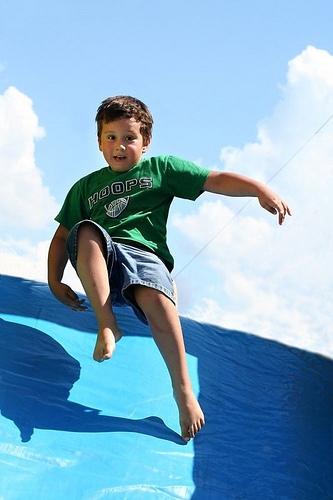

In [81]:
try_image = test_img[0]
Image.open(try_image)

In [77]:
print ('Normal Max search:', predict_captions(try_image)) 
print ('Beam Search, k=3:', beam_search_predictions(try_image, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image, beam_index=7))

FileNotFoundError: [Errno 2] No such file or directory: '3741827382_71e93298d0.jpg'

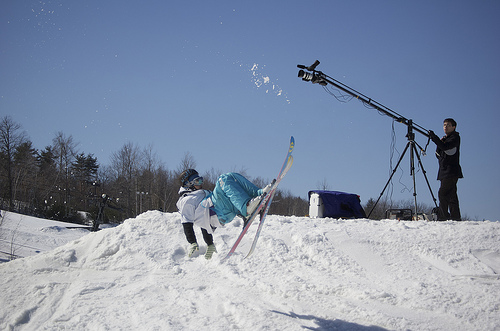

In [59]:
try_image2 = test_img[7]
Image.open(try_image2)

In [60]:
print ('Normal Max search:', predict_captions(try_image2)) 
print ('Beam Search, k=3:', beam_search_predictions(try_image2, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image2, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image2, beam_index=7))

Normal Max search: A snowboarder flies through the air after midair from a mountain .
Beam Search, k=3: A skier is performing a trick high in the air over a snowy area .
Beam Search, k=5: A downhill skier races near trees .
Beam Search, k=7: This person is snowboarding off a ramp .


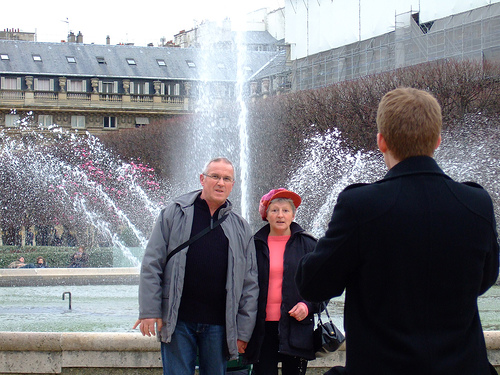

In [61]:
try_image3 = test_img[851]
Image.open(try_image3)

In [62]:
print ('Normal Max search:', predict_captions(try_image3)) 
print ('Beam Search, k=3:', beam_search_predictions(try_image3, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image3, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image3, beam_index=7))

Normal Max search: A man and a woman are standing in front of a building
Beam Search, k=3: A man and a woman are standing in front of a white building .
Beam Search, k=5: A man and a woman are standing in front of a white building .
Beam Search, k=7: A bunch of people at park .


In [78]:
try_image4 = '/usr/local/data/bonniehu/flickr_data/Flicker8k_Dataset/136552115_6dc3e7231c.jpg'
print ('Normal Max search:', predict_captions(try_image4))
print ('Beam Search, k=3:', beam_search_predictions(try_image4, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image4, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image4, beam_index=7))
Image.open(try_image4)

FileNotFoundError: [Errno 2] No such file or directory: '136552115_6dc3e7231c.jpg'

Normal Max search: A dog is jumping in the air to catch something .
Beam Search, k=3: A brown dog is jumping in the air .
Beam Search, k=5: A white dog is jumping in the air to catch a soccer ball .
Beam Search, k=7: A white dog is jumping in the air to catch a soccer ball .


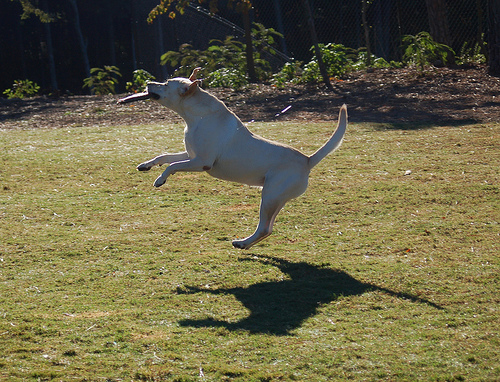

In [82]:
im = '/usr/local/data/bonniehu/flickr_data/Flicker8k_Dataset/1674612291_7154c5ab61.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

Normal Max search: A German shepherd is playing with a red ball .
Beam Search, k=3: a tan dog running through snow
Beam Search, k=5: Large brown dog running through snow with two bright trees nearby .
Beam Search, k=7: There is a tan dog in a snowy field .


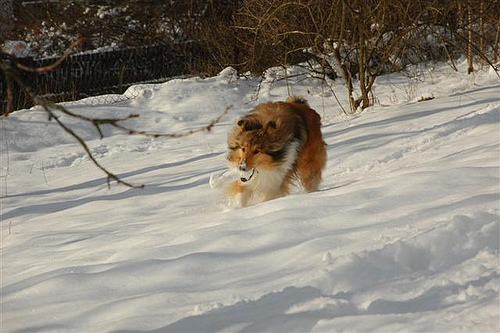

In [84]:
im = '/usr/local/data/bonniehu/flickr_data/Flicker8k_Dataset/384577800_fc325af410.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

Normal Max search: A man is riding a surfboard
Beam Search, k=3: A man rides a wave on a surfboard .
Beam Search, k=5: A man rides a surfboard as a wave makes a splash .
Beam Search, k=7: A man rides a surfboard as a wave makes a splash .


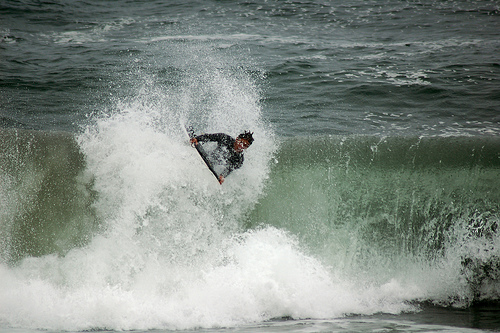

In [66]:
im = 'Flickr8k_Dataset/Flicker8k_Dataset/3631986552_944ea208fc.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

Normal Max search: A little girl in a red coat plays in snow .
Beam Search, k=3: A little kid plays in the snow in a brown jacket and red shorts on a harness .
Beam Search, k=5: Little girl in red coat going down a hill .
Beam Search, k=7: Little girl in red coat going down a hill .


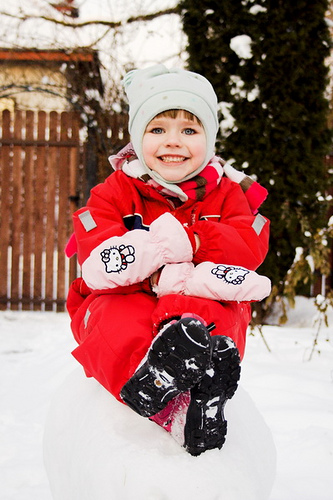

In [67]:
im = 'Flickr8k_Dataset/Flicker8k_Dataset/3320032226_63390d74a6.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

Normal Max search: A man rides a bicycle on a trail down a river .
Beam Search, k=3: A man is riding a bicycle on a trail through some trees .
Beam Search, k=5: A man rides a mountain bike down a slope in the woods .
Beam Search, k=7: A man rides a bicycle on a trail down a river .


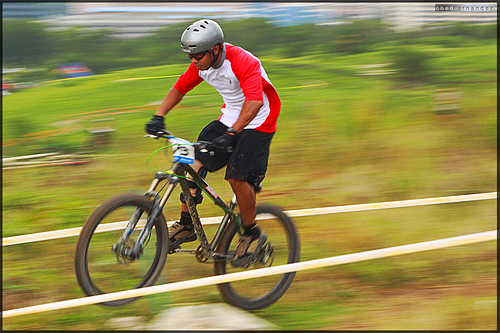

In [73]:
im = 'Flickr8k_Dataset/Flicker8k_Dataset/3316725440_9ccd9b5417.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

Normal Max search: A skateboarder in the air in front of a red slide .
Beam Search, k=3: A skateboarder in the air in front of a blue building .
Beam Search, k=5: A skateboarder in the air in front of a blue building .
Beam Search, k=7: A male skateboarder is skating in a skate park .


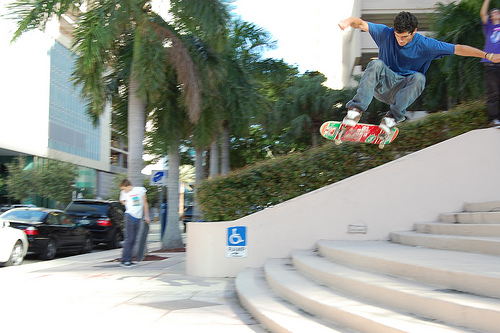

In [69]:
im = 'Flickr8k_Dataset/Flicker8k_Dataset/2306674172_dc07c7f847.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

Normal Max search: A small dog jumping an obstacle in a grassy field .
Beam Search, k=3: A small dog jumping an obstacle in a grassy field .
Beam Search, k=5: A small dog jumping an obstacle in a grassy field .
Beam Search, k=7: A small dog jumping an obstacle in a grassy field .


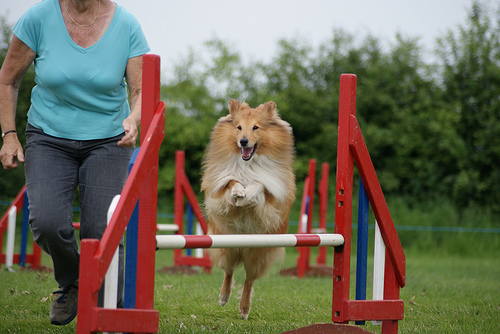

In [77]:
im = 'Flickr8k_Dataset/Flicker8k_Dataset/2542662402_d781dd7f7c.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

Flickr8k_Dataset/Flicker8k_Dataset/3123351642_3794f2f601.jpg
Normal Max search: A snowboarder is riding down the ramp next to a hill .
Beam Search, k=3: A person on a snowboard jumps over a cliff in the snow .
Beam Search, k=5: A person on a snowboard jumps over a cliff in the snow .
Beam Search, k=7: A person on a snowboard jumps over a cliff in the snow .


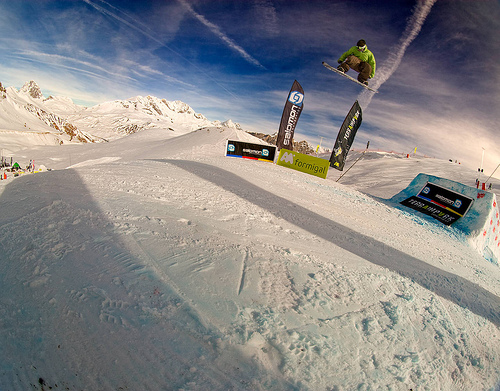

In [103]:
im = test_img[int(np.random.randint(0, 1000, size=1))]
print (im)
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)